In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import glob
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize
import time
import models
import pca
import preprocessor

### Prepocessing 
- Take images and resize to $64 \times 64 $
- <font color='red'> Note resizing degrades picture quality, will blame this later on<font>

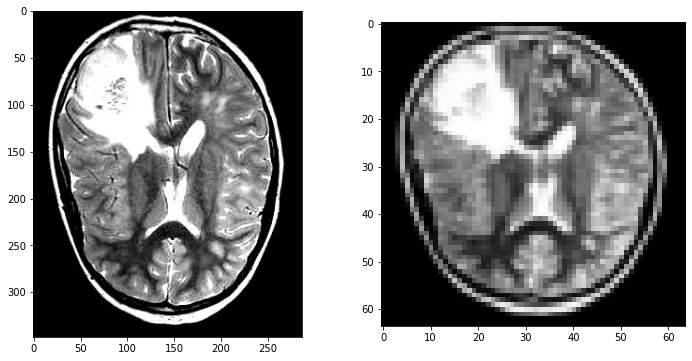

In [2]:
img = plt.imread('y0.jpg')
resized = resize(img,(64,64),anti_aliasing=True)
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(img,cmap='gray')
ax[1].imshow(resized,cmap='gray')

In [3]:
# def resize_images(path):
#     no_files = glob.glob('data/'+path+'/no/*.jpg')
#     yes_files = glob.glob('data/'+path+'/yes/*.jpg')
    
#     # saving no files 0
#     for i in range(len(no_files)):
#         image=plt.imread(no_files[i])
#         image=color.rgb2grey(image)
#         image_resized = resize(image,(64,64),
#                                anti_aliasing=True)
        
#         plt.imsave("new-data/"+path+"/no/"+str(i)+".jpg",image_resized,cmap="gray")
    
#     # saving yes files
#     for i in range(len(yes_files)):
#         image=plt.imread(yes_files[i])
#         image=color.rgb2grey(image)
#         image_resized = resize(image,(64,64),
#                                anti_aliasing=True)
        
#         plt.imsave("new-data/"+path+"/yes/"+str(i)+".jpg",image_resized,cmap="gray")
        

# Loading training & testing data

- Class encodings
 - 0 : no brain tumor
 - 1: brain tumor


In [4]:
# load data
def load_data(path):
    # get filenames and total
    no_files = glob.glob('data/'+path+'/no/*.jpg')
    yes_files = glob.glob('data/'+path+'/yes/*.jpg')
    total=len(no_files)+len(yes_files)
    
    #arrays to store data
    x=np.ones((total,64*64))
    y=np.ones((total,))
    
    #load no tumor images belonging to class 0
    i=0
    for filename in no_files:
        image=plt.imread(filename)
        if image.ndim>2:
            image=image[:,:,0]
        x[i,:]=image.flatten()
        y[i]=0
        i=i+1
    
    #load tumor images belonging to class 1
    for filename in yes_files:
        image=plt.imread(filename)
        if image.ndim>2:
            image=image[:,:,0]
        x[i,:]=image.flatten()
        y[i]=1
        i=i+1

    idx=np.arange(len(x))
    np.random.shuffle(idx)
    x=x[idx]
    y=y[idx]
    return x,y

# convert a flattened array back to image
def vec_to_image(v):
    img = v.reshape(64,64)
    return img


In [5]:
x_train,y_train=load_data("training")
x_test,y_test=load_data("testing")
# np.unique(y_train,return_counts=True)

 # Dimensionality reduction
 - Principal component analysis
 The resized images have dimensions $64\times64$,a single image corresponds to a feature vector of dimensions $1\times4\ 096$. The dimensionality of the feature space is too high and will make the models computationally expensive. We use principal component analysis with the requirement that the total retained variance must be at least $95\%$. Visual representation are shown below

In [6]:
reducer =pca.PrincipalComponentAnalysis(x_train)

#### Visualization of d components reconstruction

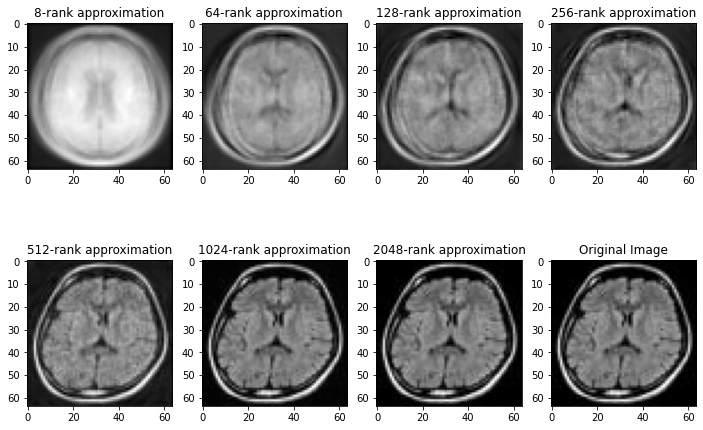

In [7]:
d_ranks = [8,64,128,256,512,1024,2048,4096]
r = 0
images = [reducer.d_rank_approximation(x_train[:1],i) for i in d_ranks]
fig,axis = plt.subplots(2,4,figsize=(12,8))
for i in range(2):
    for j in range(4):
        if r!=7:
            axis[i,j].imshow(vec_to_image(images[r].real),cmap='gray')
            axis[i,j].title.set_text(str(d_ranks[r])+'-rank approximation')
        else:
            axis[i,j].imshow(vec_to_image(x_train[0]),cmap='gray')
            axis[i,j].title.set_text('Original Image')
        r = r+1

/home/tshepang/PREFIX=/home/tshepang/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tshepang/PREFIX=/home/tshepang/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/tshepang/PREFIX=/home/tshepang/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Number of components for 98% variation  470


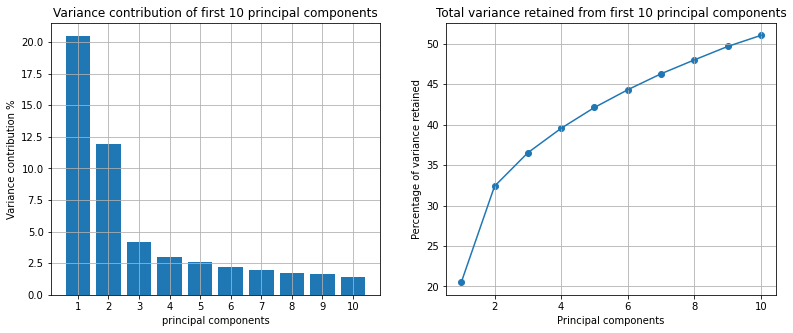

In [8]:
variances = reducer.variance_contributions()[:10]
components = 1+np.arange(len(variances))
fig,axis=plt.subplots(1,2,figsize=(13,5))
axis[0].grid()
axis[0].set(xlabel="principal components",ylabel="Variance contribution %",
            title="Variance contribution of first 10 principal components")
axis[0].bar(components.astype(str),variances*100)
cumulative_variances = np.cumsum(variances)
axis[1].grid()
axis[1].set(xlabel="Principal components",ylabel="Percentage of variance retained",
            title="Total variance retained from first 10 principal components")
axis[1].scatter(components,cumulative_variances*100)
axis[1].plot(components,cumulative_variances*100)
d = reducer.variation(0.98)
print("Number of components for 98% variation ",d)

#### Fit pca transformation to data
Transform data keeping 98% variation

In [9]:
x_train_pca = reducer.d_principal_components(x_train,d).real
x_test_pca= reducer.d_principal_components(x_test,d).real

#### Some plotting stuff

In [10]:
def cost_curve(J,title,xlabel,c):
    fig = plt.figure()
    plt.plot(np.arange(len(J)), J,c=c)
    plt.xlabel(xlabel)
    plt.ylabel(r'$J(\Theta)$')
    plt.grid()
    plt.title(title)
    # plt.savefig("batch.png") # if wanna save plot
    return ax

# Model fitting
We are now ready to train a model on the data, but first we must do feature scaling using standardization
<!-- 
$$ X_i = \frac{X_i - X_{i,min}}{X_{i,max}-X_{i,min}} \quad i = 1,2,3,.....,f$$ -->

#### feature scaling

In [11]:
scaler = preprocessor.DataPreprocessor(x_train_pca)
x_train_n = scaler.fit_transform(x_train_pca,'s')
x_test_n = scaler.fit_transform(x_test_pca,'s')

### Baseline model 
The baseline model will be logistic regression in which the underlying learning algorithm and kNN 

## $k$NN

Training accuracy 3-NN 98.54166666666667
Testing accuracy 3-NN 94.83333333333334
Computation time for testing in seconds 3.08


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted labels', ylabel='True labels'>

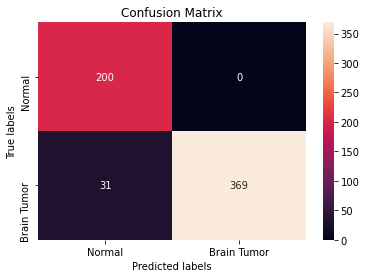

In [12]:
# errors={}
# K=np.arange(3,15,2)
# perfomance=[]
# for k in K:
#     knn=models.kNN(x_train_n,y_train,k)
#     perfomance=(knn.training_fit())
#     errors[str(k)+"-NN"]=np.round(1-perfomance,3)
    
# print("Training errors:",errors)
knn=models.kNN(x_train_pca,y_train,3)
print("Training accuracy 3-NN",100*knn.training_fit())
start=time.time()
print("Testing accuracy 3-NN",100*knn.testing_fit(x_test_pca,y_test))
end=time.time()
print("Computation time for testing in seconds",round(end-start,2))
knn.confusion_matrix(x_test_pca,y_test)

## Logistic Regression 

### Gradient descent learning


In [13]:
alpha= 0.5 # learning rate
gamma = 0.000 # regularization strngeth
epsilon=1e-3 # tolerance
t_max= 500 # maximum iterations

#### full batch gradient descent

Random parameters training accuracy 48.791666666666664 %
Learning time 5.521510601043701 seconds
Training accuracy: 99.79166666666667 %
Testing accuracy: 96.83333333333334 %

193
388


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

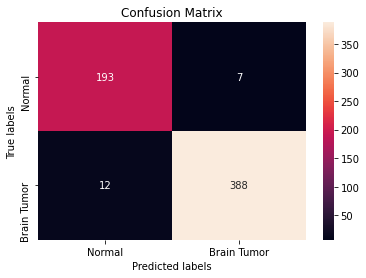

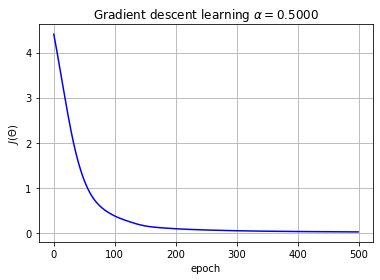

In [14]:
lr= models.LogisticRegression(x_train_n,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="bgd",alpha=alpha,epsilon=epsilon,gamma=gamma,t_max=t_max)
end=time.time()
J=lr.J
print("Learning time",end-start,"seconds")
print("Training accuracy:",lr.training_fit()*100,"%")
print("Testing accuracy:",lr.testing_fit(x_test_n,y_test)*100,"%\n")
ax_cm = lr.confusion_matrix(x_test_n,y_test)
title = r'Gradient descent learning $\alpha={:.4f}$'.format(alpha)
cost_curve(J,title,'epoch','b')

#### Mini batch gradient descent 

Random parameters training accuracy 48.583333333333336 %
Learning time 4.076800346374512 seconds
Training accuracy: 99.16666666666667 %
Testing accuracy: 97.16666666666667 %


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

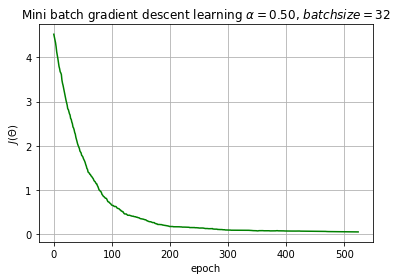

In [15]:
lr=models.LogisticRegression(x_train_n,y_train)
batch_size=32
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="mbgd",alpha=alpha,epsilon=epsilon,gamma=gamma,batch_size=batch_size,t_max=t_max)
end=time.time()
J = lr.J
print("Learning time",end-start,"seconds")
print("Training accuracy:",lr.training_fit()*100,"%")
print("Testing accuracy:",lr.testing_fit(x_test_n,y_test)*100,"%")
title = r'Mini batch gradient descent learning $\alpha={:.2f}$, $batch size=${:}'.format(alpha,batch_size)
cost_curve(J,title,'epoch','g')
# lr.confusion_matrix(x_test_n,y_test)

#### Stochastic gradient descent 

Random parameters training accuracy 48.70833333333333 %
Learning time 1.66510009765625 seconds
Training accuracy: 73.16666666666667 %
Testing accuracy: 70.16666666666667 %


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

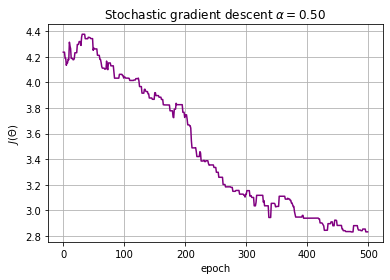

In [16]:
lr= models.LogisticRegression(x_train_n,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="sgd",alpha=alpha,epsilon=epsilon,gamma=gamma,t_max=t_max)
end=time.time()
J =lr.J
print("Learning time",end-start,"seconds")
print("Training accuracy:",lr.training_fit()*100,"%")
print("Testing accuracy:",lr.testing_fit(x_test_n,y_test)*100,"%")
title = r'Stochastic gradient descent $\alpha={:.2f}$'.format(alpha)
cost_curve(J,title,'epoch','purple')
# lr.confusion_matrix(x_test_n,y_test)

### Global optimization based learning

#### Genetic algorithm
- Tournament selection , eleptical crossing over 
- $N$ : Number of individuals in population (candidate solutions) <br>
- $m$ : Number of individuals yo replace each generation
The implementation has mutation activated (with mutation region $p=0.1$)

In [17]:
N=50
m=10

Random parameters training accuracy 50.541666666666664 %
Learning time 47.01751208305359 seconds
Training accuracy: 75.41666666666667 %
Testing accuracy: 74.33333333333333 %


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

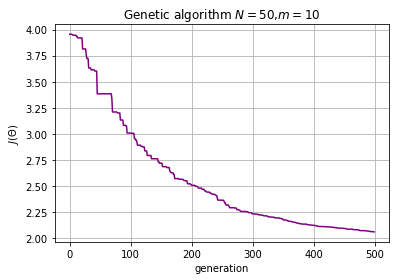

In [18]:
lr= models.LogisticRegression(x_train_n,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="ga",t_max=t_max,N=N,m=m)
end=time.time()
J = lr.J
print("Learning time",end-start,"seconds")
print("Training accuracy:",lr.training_fit()*100,"%")
print("Testing accuracy:",lr.testing_fit(x_test_n,y_test)*100,"%")
title = r'Genetic algorithm $N={:}$,$m={:}$'.format(N,m)
cost_curve(J,title,'generation','purple')

#### Particle swarm optimization
- Base implementaion with constant inertia $w=0.6$
- $N$: Number of particles in swarm

In [19]:
N=50

Random parameters training accuracy 52.583333333333336 %


/home/tshepang/Documents/Machine Learning/Final Project/skaps/models.py:16: RuntimeWarning: overflow encountered in exp
  y=1/(1+np.exp(-np.dot(x,theta)))


Learning time 23.265762329101562 seconds
Training accuracy: 65.66666666666666 %
Testing accuracy: 74.16666666666667 %


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

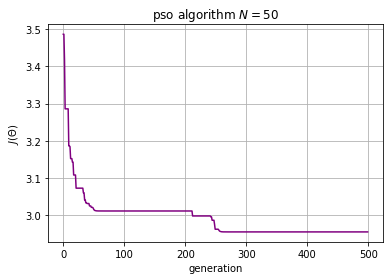

In [20]:
lr= models.LogisticRegression(x_train_n,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="pso",t_max=t_max,N=N)
end=time.time()
J =lr.J
print("Learning time",end-start,"seconds")
print("Training accuracy:",lr.training_fit()*100,"%")
print("Testing accuracy:",lr.testing_fit(x_test_n,y_test)*100,"%")
title = r'pso algorithm $N={:}$'.format(N)
cost_curve(J,title,'generation','purple')

# <font color='red'> Why We did dimensionality reduction ?
The answer is to reduce computation time and potentialy disregard insignificant data/noise in data 

#### Our gradient descent with dimensionality reduction 

In [21]:
scaler = preprocessor.DataPreprocessor(x_train)
X_train_n = scaler.fit_transform(x_train,'s')
X_test_n = scaler.fit_transform(x_test,'s')

Random parameters training accuracy 60.20833333333333 %
Learning time 40.06470036506653 seconds
Training accuracy: 99.875 %
Testing accuracy: 92.0 %



array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

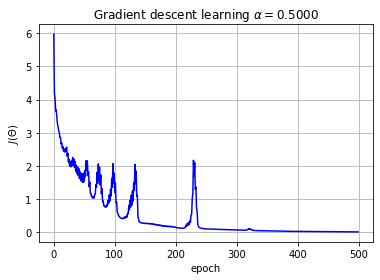

In [22]:
lr= models.LogisticRegression(X_train_n,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="bgd",alpha=alpha,epsilon=epsilon,gamma=gamma,t_max=t_max)
end=time.time()
J=lr.J
print("Learning time",end-start,"seconds")
print("Training accuracy:",lr.training_fit()*100,"%")
print("Testing accuracy:",lr.testing_fit(X_test_n,y_test)*100,"%\n")
# ax_cm = lr.confusion_matrix(x_test_n,y_test)
title = r'Gradient descent learning $\alpha={:.4f}$'.format(alpha)
cost_curve(J,title,'epoch','b')

## <font color='red'> Things to talk about
    
  <font color='red'>  - initially preprocessing in which some data was lost (resizing of images )
- dimensionality reduction (pca cons), efficiency
- gradient descent (mini batch,stochastic)  effectively stochastic is to make things fast
- gradient descent vs global optimization (are the GO algorithms worth it in this case?, remember these were in their simplest form), they can be quite expensive
- What could have been done (maybe apply image processing techniques to images to highlight regions of importance) ? or try out more sophisticated versions of gradient descent and GO algorithms </font>